# 1.라이브러리 설치

In [ ]:
 !python --version

Python 3.9.16


# 2. video.zip 파일의 압축을 풀어줌

In [ ]:
import zipfile

zip_file=zipfile.ZipFile("video.zip")
zip_file.extractall()

# 3.라이브러리 불러오기

In [ ]:
import os
import random
import fnmatch
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

print( f'np.__version__: {np.__version__}' )
print( f'pytorch.__version__: {torch.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image

#GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

np.__version__: 1.22.4
pytorch.__version__: 1.13.1+cu116
cuda:0


# 4.데이터 불러오기

image_path: ./video/train_00547_135.png
steering_Angle: 135


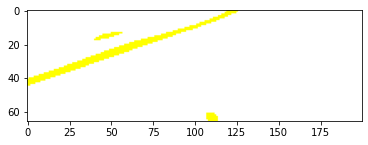

In [ ]:
data_dir = './video/'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = "*.png"
for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(data_dir,filename))
        angle = int(filename[-7:-4]) 
        steering_angles.append(angle)

image_index = 1
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index] )
print("steering_Angle: %d" % steering_angles[image_index] )
df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

# 5.조향각의 분포를 확인



(array([49.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 541.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        841.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

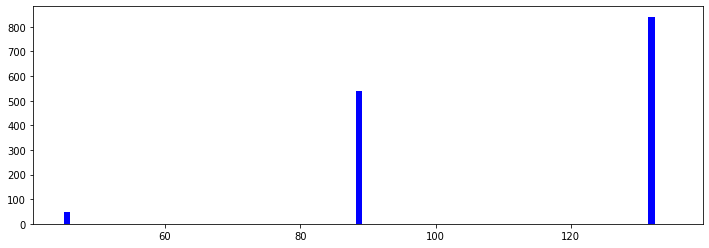

In [ ]:
num_of_bins = 25 
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'], bins=num_of_bins, width=1, color='blue')

# 6. 학습데이터와 검증데이터를 분리

Training data: 915
Validation data: 229


Text(0.5, 1.0, 'Validation Data')

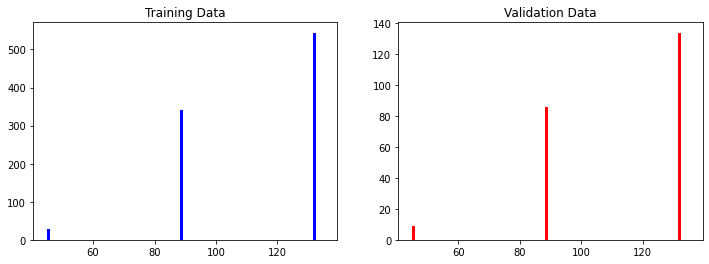

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steering_angles, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')
axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

# 7. 이미지 읽어오기 및 정규화함수

Text(0.5, 1.0, 'processed')

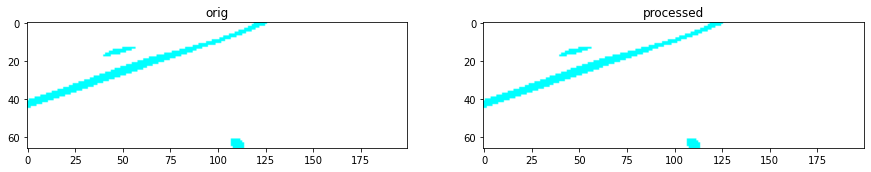

In [ ]:
def my_imread(image_path):
    image = cv2.imread(image_path)
    return image

def img_preprocess(image):
    image = image / 255
    return image

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
image_orig = my_imread(image_paths[image_index])
image_processed = img_preprocess(image_orig)
axes[0].imshow(image_orig)
axes[0].set_title("orig")
axes[1].imshow(image_processed)
axes[1].set_title("processed")

# 8. nvidia 모델구성

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class NvidiaModel(nn.Module):
    def __init__(self):
        super(NvidiaModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels= 24, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0))
        self.conv2 = nn.Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0))
        self.conv3 = nn.Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2), padding=(0, 0))
        self.conv4 = nn.Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        self.dropout1 = nn.Dropout2d(p=0.2)
        self.conv5 = nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(0, 0))
        self.flatten = nn.Flatten()
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(64 * 1 * 18, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, x):
        x = nn.functional.elu(self.conv1(x))
        x = nn.functional.elu(self.conv2(x))
        x = nn.functional.elu(self.conv3(x))
        x = nn.functional.elu(self.conv4(x))
        x = self.dropout1(x)
        x = nn.functional.elu(self.conv5(x))
        x = self.flatten(x)
        x = self.dropout2(x)
        x = nn.functional.elu(self.fc1(x))
        x = nn.functional.elu(self.fc2(x))
        x = nn.functional.elu(self.fc3(x))
        x = self.output(x)
        return x

model = NvidiaModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

NvidiaModel(
  (conv1): Conv2d(3, 24, kernel_size=(5, 5), stride=(2, 2))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(2, 2))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(2, 2))
  (conv4): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=1152, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)


# 9. 학습데이터 생성

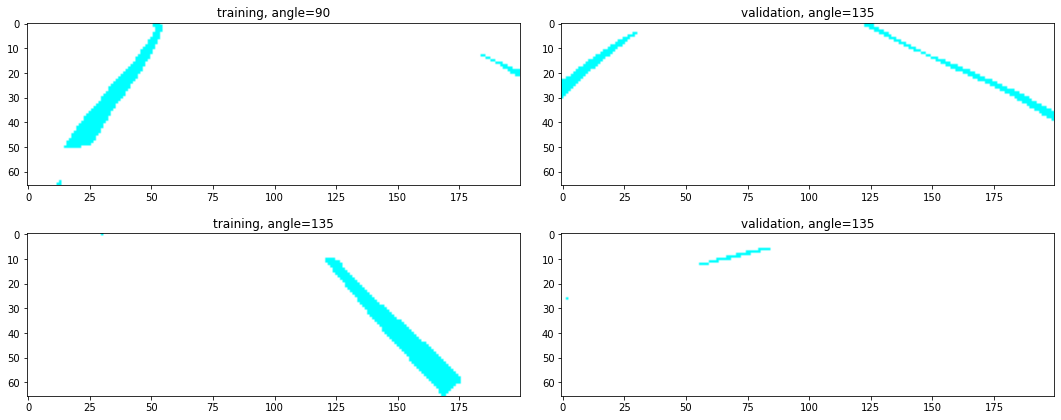

In [ ]:
def image_data_generator(image_paths, steering_angles, batch_size):
    while True:
        batch_images = []
        batch_steering_angles = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            image_path = image_paths[random_index]
            image = my_imread(image_paths[random_index])
            steering_angle = steering_angles[random_index]
            
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
            
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, angle=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [ ]:
!pip install IQA_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 KB 2.4 MB/s eta 0:00:00


In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from IQA_pytorch import DISTS, utils

class LaneNavigationDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        for i in range(len(self.y)):

            image_path = self.X[i]
            image = my_imread(self.X[i])
            steering_angle = self.y[i]
            
            image = img_preprocess(image)

            if self.transform:
                image = utils.prepare_image(image)
                image = image.squeeze()
                image = self.transform(image)
                steering_angle = torch.tensor(steering_angle)

        return image, steering_angle

transform = transforms.Compose([ 
                                transforms.ToPILImage(),
                                transforms.Resize((66, 200)),
                                transforms.ToTensor(),
                                ])

In [ ]:
train_dataset = LaneNavigationDataset(X_train, y_train, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

valid_dataset = LaneNavigationDataset(X_valid, y_valid, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=100, shuffle=False)

test_dataset = LaneNavigationDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

# 10.모델 학습(5~10분가량 소요)

In [ ]:
from torch.utils.tensorboard import SummaryWriter

model_output_dir = r"./"

# Tensorboard summary writer
writer = SummaryWriter()

num_epochs = 10
validation_loss = 10
for epoch in range(num_epochs):
    # Train
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data

        #GPU 사용
        if torch.cuda.is_available():
            inputs = inputs.to(device)
            labels = labels.to(device)
            model = model.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.float()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    
    # Validation
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            inputs, labels = data

             #GPU 사용
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)
                model = model.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        valid_loss = running_loss / len(valid_loader)
    
    # Write to Tensorboard
    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/valid', valid_loss, epoch)
    
    # Print progress
    print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format( 
        epoch+1, num_epochs, train_loss, valid_loss))

    # Save best model
    if valid_loss < validation_loss:
        validation_loss = valid_loss
        torch.save(model.state_dict(), os.path.join(model_output_dir,'lane_navigation_check.pth'))

# Save final model
torch.save(model.state_dict(), os.path.join(model_output_dir,'lane_navigation_final.pth'))

# Close Tensorboard writer
writer.close()


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([87])) that is different to the input size (torch.Size([87, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, 

Epoch [1/10], Train Loss: 11490.0704, Valid Loss: 119.3680
Epoch [2/10], Train Loss: 1413.9423, Valid Loss: 301.6937
Epoch [3/10], Train Loss: 420.9894, Valid Loss: 314.7054
Epoch [4/10], Train Loss: 218.9071, Valid Loss: 164.1906
Epoch [5/10], Train Loss: 131.9354, Valid Loss: 119.8548
Epoch [6/10], Train Loss: 122.8866, Valid Loss: 102.3969
Epoch [7/10], Train Loss: 117.5730, Valid Loss: 96.1377
Epoch [8/10], Train Loss: 103.3384, Valid Loss: 142.6054
Epoch [9/10], Train Loss: 101.4025, Valid Loss: 93.4008
Epoch [10/10], Train Loss: 101.8993, Valid Loss: 116.9816


# 11. 결과확인
- https://tutorials.pytorch.kr/recipes/recipes/tensorboard_with_pytorch.html

# 12. 검증

<class 'list'>
<class 'torch.Tensor'>
mse       = 1.1e+03
r_squared = -69.75%



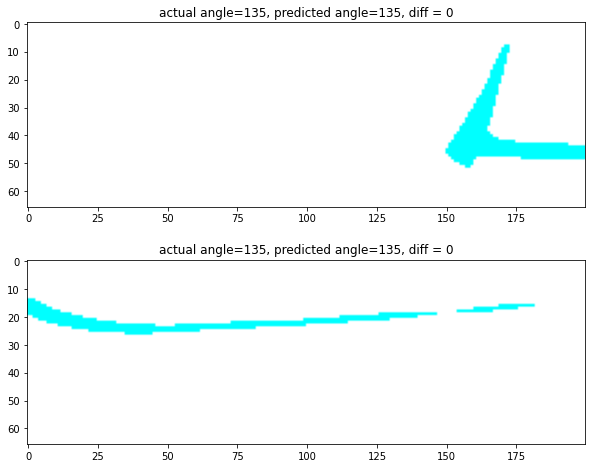

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# model_output_dir = r"./"
model_output_dir = '/content/drive/MyDrive/jaesungpark_lab/self-driving car'

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y, model):
    model.load_state_dict(torch.load(f'{model_output_dir}/lane_navigation_final.pth'))
    model.eval()
    Y_pred = []
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            inputs, labels = data

            #GPU 사용
            if torch.cuda.is_available():
                inputs = inputs.to(device)
                labels = labels.to(device)
                model = model.to(device)
            
            outputs = model(inputs)
            prediction = outputs.max(1, keepdim = True)[1]
            Y_pred.extend(outputs)
            
            
    Y_pred = torch.tensor(Y_pred)
    summarize_prediction(Y, Y_pred)
    return Y_pred

test_dataset = LaneNavigationDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

y_pred = predict_and_summarize(X_test, y_test, model)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    image = cv2.imread(X_test[i])
    axes[i].imshow(image)
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")